# Scintillation Tutorial
* In this tutorial, you will analyze a NANOGrav data set of pulsar J1713+0747 obtained during the global campaign on June 23, 2013.
<br>
<br>
* First, we import the required libraries, modules and packages.

In [1]:
%matplotlib notebook
import psrchive
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

* The path to the data set is `/nanograv/notebook/homes/jupyterhub-benetgeperera/tutorials/GUPPI_J1713+0747_56466_10724_all.zap.tp`.


* This data set is already processed using a timing model of the pulsar.


* We can load and read in the data set using the PSRCHIVE package (http://psrchive.sourceforge.net). PSRCHIVE is a standard pulsar data analyzing package.


In [2]:
fn = 'GUPPI_J1713+0747_56466_10724_all.zap.tp'

# Read in the data archive
obs = psrchive.Archive_load(fn)
obs.dedisperse()
obs.pscrunch()
obs.remove_baseline()


* Extract the data and stored in `data` array. 


* Let's print the shape of the `data` array

In [3]:
obs.get_source()

#Import the data and store in "data" array
data = obs.get_data()


#Shape of the "data" array
print('Shape of the data array:')
data.shape


Shape of the data array:


(866, 1, 128, 1024)



* The `data` array has 4 dimensions: 


-first dimension: Number of Time sub-integrations. Each sub-integration is 30 sec.
<br>
-second dimension: Number of Polarization channels. We use the Total Intensity, so there is one Pol channel.
<br>
-third dimension: Number of Frequency channels. Each channel has a bandwidth of 6.2 MHz.
<br>
-fourth dimension: Number of Phase bins across the pulse profile.




In [4]:
nsub = data.shape[0]
nchan = data.shape[2]
nbins = data.shape[3]

tsub = 30.           #each time subint is 30 sec
f_low = 1100.        #lowest frequency channel
f_high = 1893.75     #highest frequency channel
ch_bw = (f_high - f_low)/(1.*nchan)     #BW of a frequency channel

#Apply weights to mask bad channels (i.e. weight = 0).
if nchan > 1:
    weights = obs.get_weights()
    for ww in range(nbins):
        data[:,0,:,ww] *= weights

## Get the pulse profile of the pulsar

* Let's plot the integrated (or averaged) pulse profile. 


* In order to do that, we need to average all frequency channels and time sub-integrations.

<IPython.core.display.Javascript object>


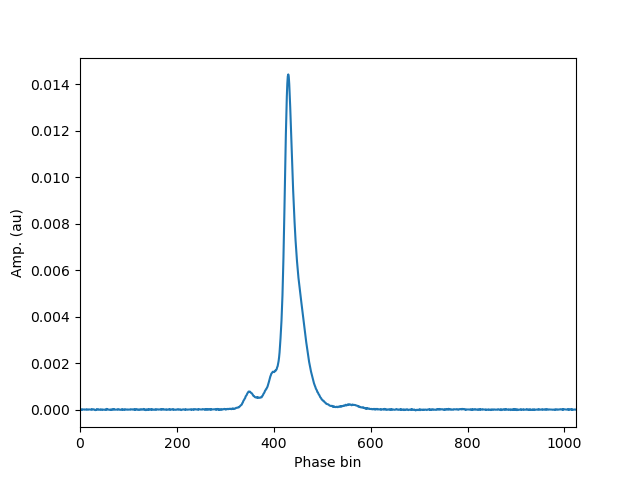

In [5]:
prof = np.mean(np.mean(data, axis=2), axis=0)[0,:]

plt.figure()
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Amp. (au)')
plt.plot(np.arange(nbins), prof)

## Plot the subintegrations

* Let's plot the sub-integrated profiles


* In order to do that, we need to average all frequency channels.

<IPython.core.display.Javascript object>


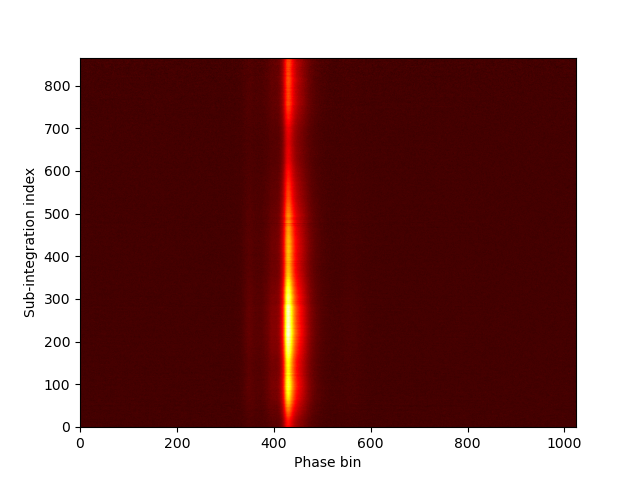

In [6]:
subint_profs = np.mean(data, axis=2)[:,0,:]

plt.figure()
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Sub-integration index')
plt.imshow(subint_profs, aspect='auto', origin='lower',cmap='hot')

## Plot the time-averaged profile across the bandwidth

* Let's plot the time-averaged profiles across the bandwidth


* In order to do that, we need to average all the subintegrations.

<IPython.core.display.Javascript object>


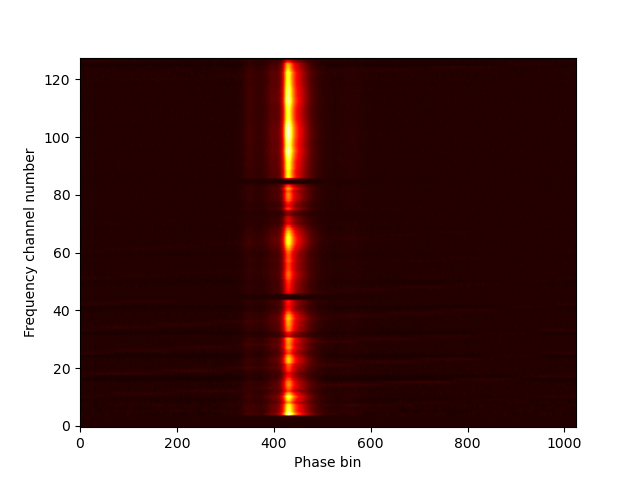

In [7]:
freq_profs = np.mean(data, axis=0)[0,:,:]

plt.figure()
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Frequency channel number')
plt.imshow(freq_profs, aspect='auto', origin='lower',cmap='hot')

## Get the dynamic spectrum of the data set

* The dynamic spectrum presents the energy of the pulses in Frequency vs. Time space.


* Exercise: Select the on-pulse region (onstr, onstp) to compute the energy, and enter below.


In [8]:
onstr = 320
onstp = 600

* Energy of the pulse can be obtained by taking the area under the pulse. Simply, we can add all Y values of the pulse within the on-pulse region!


* Let's now compute the energy and make the dynamic spectrum.

<IPython.core.display.Javascript object>


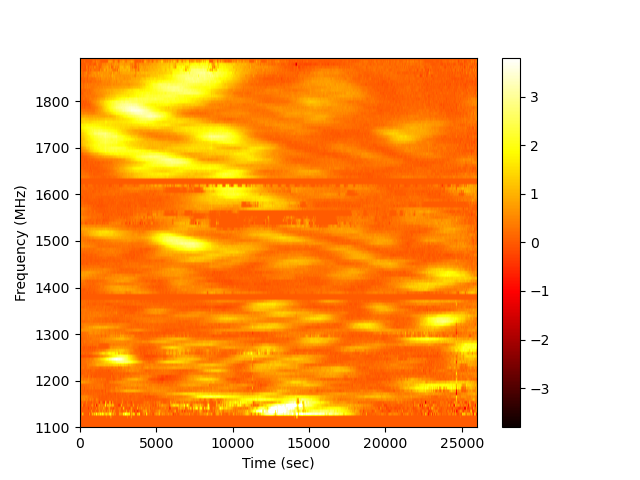

In [9]:
dyn = np.zeros((nchan,nsub))
for i in range(nsub):
    for j in range(nchan):
        dyn[j,i] = np.sum(data[i,0,j,onstr:onstp])
        if dyn[j,i] == 0:
            dyn[j,i] = 0.001

std = np.std(dyn)
plt.figure()
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (MHz)')
plt.imshow(dyn, aspect='auto', origin='lower',cmap='hot', extent=[0*tsub, nsub*tsub, f_low,f_high], 
           vmin=-6.*std, vmax=6.*std)
plt.colorbar()

* Now you can see clear patches in the dynamic spectrum. These patches are called "scintles". The pulsar emission was bright during the scintles. We can check that by plotting pulse profiles during a bright scintle and elsewhere.


* Exercise: Select the time and the frequency (time_bright, freq_bright) of a point in a bright scintle, and a point in a weak scintle (time_weak, freq_weak).

In [10]:
#select (time,freq) of a bright patch to plot the pulse profile in it
time_bright = 3210
freq_bright = 1786

#select (time,freq) of a weak region to plot the pulse profile in it
time_weak = 15000
freq_weak = 1786


* Now you can plot the pulse profiles corresponding to these selected regions.


<IPython.core.display.Javascript object>


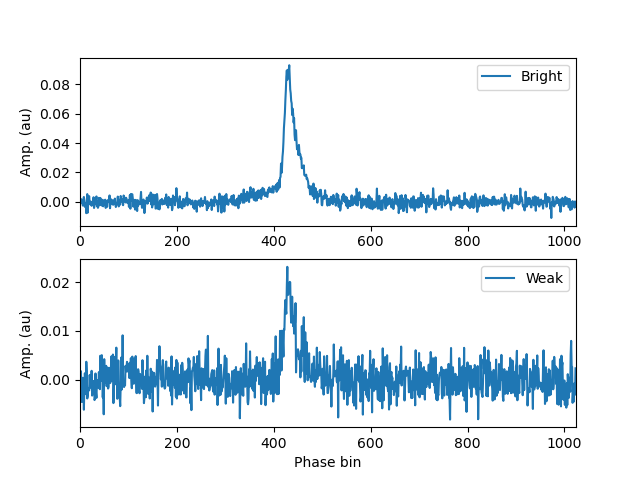

In [11]:
nsub_bright = int(time_bright/(1.*tsub))
nchan_bright = int((freq_bright - f_low)/ch_bw)

plt.figure()
plt.subplot(211)
plt.xlim(0,nbins)
plt.ylabel('Amp. (au)')
plt.plot(np.arange(nbins), data[nsub_bright,0,nchan_bright,:],label='Bright')
plt.legend(loc='best')

nsub_weak = int(time_weak/(1.*tsub))
nchan_weak = int((freq_weak - f_low)/ch_bw)

plt.subplot(212)
plt.xlim(0,nbins)
plt.xlabel('Phase bin')
plt.ylabel('Amp. (au)')
plt.plot(np.arange(nbins), data[nsub_weak,0,nchan_weak,:], label='Weak')
plt.legend(loc='best')

## Estimate the scintillation bandwidth $\Delta$f and scintillation timescale $\Delta$t.

* To do that, first we need to get the auto-correlation function (ACF) of the dynamic spectrum.


* Let's compute the ACF($\delta$f, $\delta$t) for given time lags ($\delta$t) and frequency lags ($\delta$f), and then plot it!

<IPython.core.display.Javascript object>


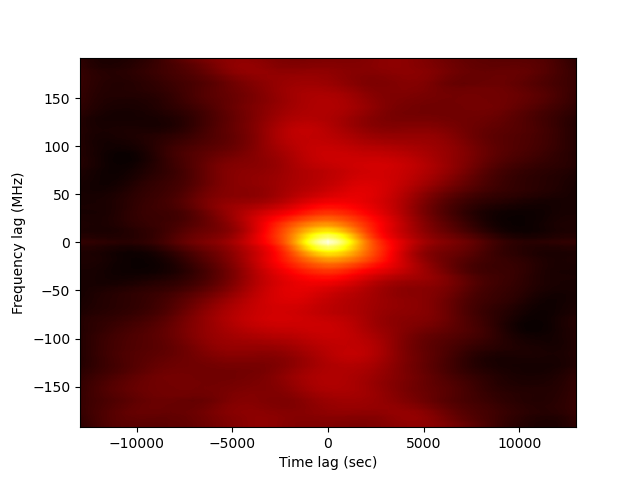

In [12]:
#time and freq lags for the auto-correlation
t_lag = np.arange(-(nsub/2.)+1, nsub/2., dtype=int)
f_lag = np.arange(-(nchan/4.)+1, nchan/4., dtype=int)
cc = np.zeros((len(f_lag),len(t_lag)))

#computing the auto-correlation coefficients
for i in range(len(f_lag)):
    for j in range(len(t_lag)):
        dyn_new = np.roll(np.roll(dyn, f_lag[i], axis=0), t_lag[j], axis=1)
        cc[i,j] = np.corrcoef(dyn.ravel(), dyn_new.ravel())[0,1]

#plotting auto-correlation        
plt.figure()
plt.xlabel('Time lag (sec)')
plt.ylabel('Frequency lag (MHz)')
plt.imshow(cc, aspect='auto', origin='lower',cmap='hot', extent=[t_lag[0]*tsub, 
                                t_lag[-1]*tsub, f_lag[0]*ch_bw, f_lag[-1]*ch_bw])


* Now, we use the ACF to get the Scintillation bandwidth. 


* We need ACF($\delta$f, 0) to get the Scintillation bandwidth, and so let's plot ACF($\delta$f, 0).


<IPython.core.display.Javascript object>


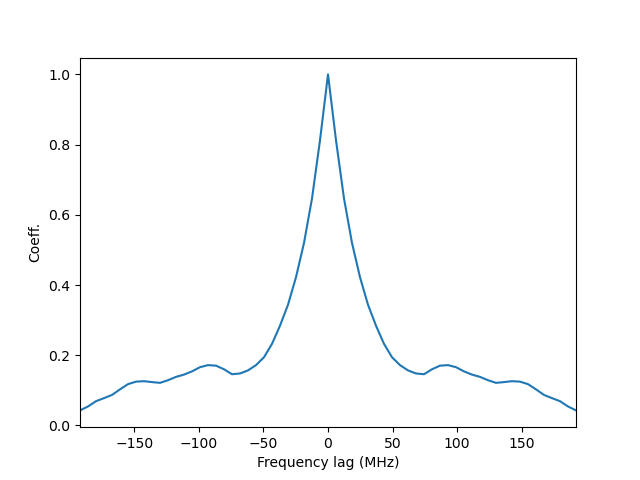

In [13]:
#find the bins of t_lag = 0
kk = np.argwhere(t_lag == 0).squeeze()
f_acf = cc[:,kk]

plt.figure()
plt.xlim(f_lag[0]*ch_bw,f_lag[-1]*ch_bw)
plt.xlabel('Frequency lag (MHz)')
plt.ylabel('Coeff.')
plt.plot(f_lag*ch_bw, f_acf)



* To get the Scintillation bandwidth, the best practice is to fit a Gaussian function to ACF($\delta$f, 0).


* Then the Scintillation bandwidth ($\Delta$f) is half width at ACF($\delta$f, 0)/2.

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<IPython.core.display.Javascript object>


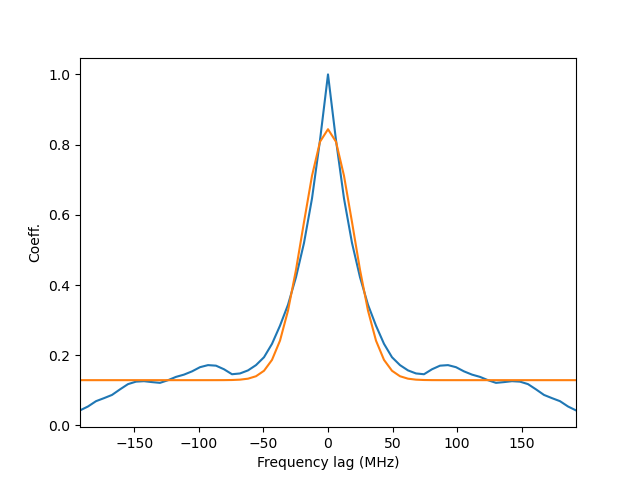


****************

Scintillation BW (MHz) = 24.8046875

****************



In [14]:
#defind the Gaussian function fit
def gauss_fit(x,*pp):
    gs = pp[0]*np.exp(-(x-pp[1])**2./(2.*pp[2]**2)) + pp[3]
    return gs

#inital guesses for the fit
pp = [1., 0., 5., 0.]
fpopt, fpcov = curve_fit(gauss_fit, f_lag, f_acf, p0=pp)
fperr = np.sqrt(np.diag(fpcov))
fgauss = gauss_fit(f_lag,*fpopt)

plt.figure()
plt.xlim(f_lag[0]*ch_bw,f_lag[-1]*ch_bw)
plt.xlabel('Frequency lag (MHz)')
plt.ylabel('Coeff.')
plt.plot(f_lag*ch_bw, f_acf)
plt.plot(f_lag*ch_bw, fgauss)

kk = np.argwhere(fgauss > np.amax(fgauss)/2.).squeeze()
print("\n****************\n")
print('Scintillation BW (MHz) =', (f_lag[kk[-1]]-f_lag[kk[0]])*ch_bw/2.)
print("\n****************\n")


* Then, we use the ACF to get the Scintillation timescale. 


* We need ACF(0, $\delta$t) to get the Scintillation timescale, and so let's plot ACF(0, $\delta$t).


<IPython.core.display.Javascript object>


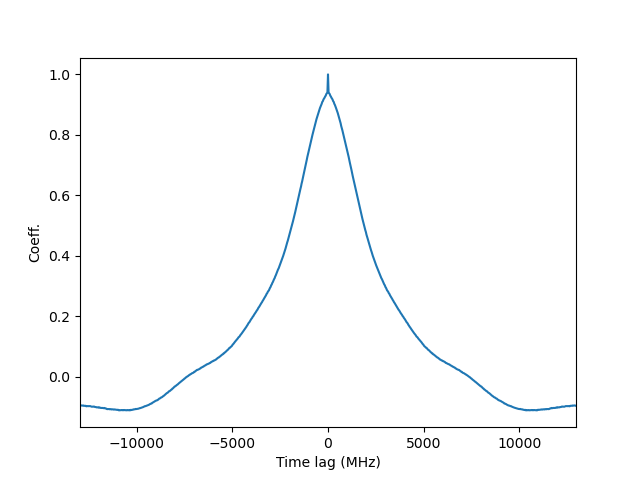

In [15]:
#find the bin of f_lag = 0
kk = np.argwhere(f_lag == 0).squeeze()
t_acf = cc[kk,:]

plt.figure()
plt.xlim(t_lag[0]*tsub,t_lag[-1]*tsub)
plt.xlabel('Time lag (MHz)')
plt.ylabel('Coeff.')
plt.plot(t_lag*tsub, t_acf)


* To get the Scintillation timescale, we fit a Gaussian function to ACF(0, $\delta$t).


* Then the Scintillation timescale ($\Delta$t) is half width at ACF(0, $\delta$f)/$e$.


<IPython.core.display.Javascript object>


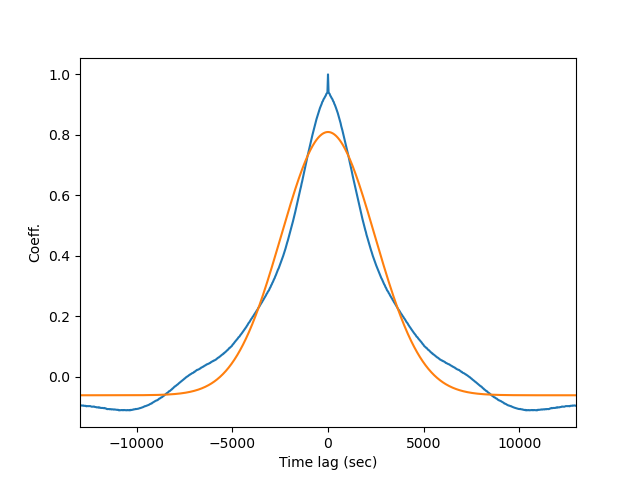


****************

Scintillation timescale (s):  3240.0
Scintillation timescale (min):  54.0

****************



In [16]:
#inital guesses for the fit
pp = [1., 0., 5., 0.]
tpopt, tpcov = curve_fit(gauss_fit, t_lag, t_acf, p0=pp)
tperr = np.sqrt(np.diag(tpcov))
tgauss = gauss_fit(t_lag,*tpopt)

plt.figure()
plt.xlim(t_lag[0]*tsub,t_lag[-1]*tsub)
plt.xlabel('Time lag (sec)')
plt.ylabel('Coeff.')
plt.plot(t_lag*tsub, t_acf)
plt.plot(t_lag*tsub, tgauss)

kk = np.argwhere(tgauss > np.amax(tgauss)/np.exp(1.)).squeeze()
print("\n****************\n")
print('Scintillation timescale (s): ', (t_lag[kk[-1]]-t_lag[kk[0]])*tsub/2.)
print('Scintillation timescale (min): ', ((t_lag[kk[-1]]-t_lag[kk[0]])*tsub/2.)/60.)
print("\n****************\n")